# Import Tensorflow and other libraries

In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import glob
import random
import subprocess

import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Tweakable Parameters

In [3]:
BUFFER_SIZE = 500
BATCH_SIZE = 4
IMAGE_WIDTH = 512
IMAGE_HEIGHT = 512

In [4]:
# Fix seeds
SEED = 42 

os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load the dataset

In [5]:
def directory_should_exist(*args):
    dir = os.path.join(*args)
    if not os.path.isdir(dir):
        raise Exception("Path '{}' is not a directory.".format(dir))
    return dir

In [6]:
def ensure_directory(*args):
    dir = os.path.join(*args)
    try:
        os.makedirs(dir)
    except OSError as err:
        if err.errno != 17:
            raise err
    return dir

In [7]:
project_dir = directory_should_exist("_projects/madina/")
dataset_dir = directory_should_exist(project_dir, "input/faces_combined/train")
output_dir = ensure_directory(project_dir, "output/v006")
model_dir = output_dir
checkpoint_dir = ensure_directory(output_dir, "checkpoints-male-to-female")
tfjs_dir = ensure_directory(output_dir, "tfjs")
log_dir = ensure_directory(output_dir, "log")
output_image_dir = ensure_directory(output_dir, "images-male-to-female")
glob_pattern = '*.jpg'

In [8]:
sample_image_filename = glob.glob(os.path.join(dataset_dir, glob_pattern))[666]
print(sample_image_filename)
sample_image = tf.io.read_file(sample_image_filename)
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

_projects/madina/input/faces_combined/train/05073.jpg
(512, 1024, 3)


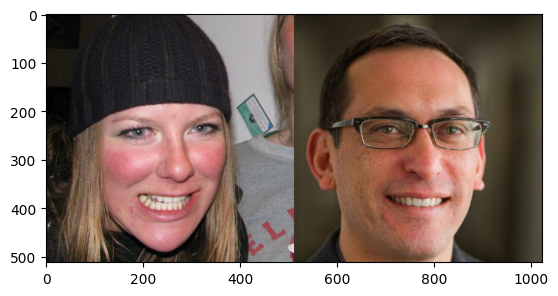

In [9]:
plt.figure()
plt.imshow(sample_image)
plt.show()

## Build an input pipeline with tf.data

In [10]:
#@tf.autograph.experimental.do_not_convert
def load_image(fname):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(fname)
    image = tf.io.decode_jpeg(image)
    
    # Split the image tensor into two tensors:
    # - The left (target) image
    # - The right (source) image
    image_width = tf.shape(image)[1]
    image_width = image_width // 2
    input_image = image[:, image_width:, :]
    real_image = image[:, :image_width, :]
    
    # If needed you can flip the direction of the training here.
    #real_image, input_image = input_image, real_image
    
    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)
        
    return input_image, real_image

In [11]:
def normalize_images(input_image, real_image):
    # Normalize the images to [-1, 1]
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [12]:
def resize_image(input_image, real_image, width, height):
    # Note that the order of width/height in tensorflow is reversed:
    input_image = tf.image.resize(input_image, [height,width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height,width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

In [13]:
def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

In [14]:
def random_jitter(input_image, real_image):
    # Resize the image to 572 x 572
    input_image, real_image = resize_image(input_image, real_image, IMAGE_WIDTH + 60, IMAGE_HEIGHT + 60)
    # Randomly crop the image back to 512x512
    input_image, real_image = random_crop(input_image, real_image)
    # Randomly flip the image
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image


In [15]:
def process_image(fname):
    input_image, real_image = load_image(fname)
    input_image, real_image = normalize_images(input_image, real_image)
    input_image, real_image = random_jitter(input_image, real_image)
    return input_image, real_image

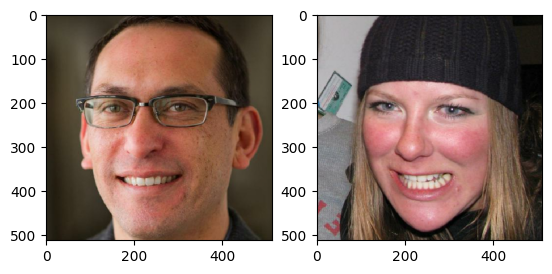

In [16]:
sample_input_image, sample_real_image = process_image(sample_image_filename)
fig = plt.figure()
fig.add_subplot(1, 2, 1).imshow(sample_input_image * 0.5 + 0.5)
fig.add_subplot(1, 2, 2).imshow(sample_real_image  * 0.5 + 0.5)
plt.show()

In [17]:
train_dataset = tf.data.Dataset.list_files(os.path.join(dataset_dir, glob_pattern))
train_dataset = train_dataset.map(process_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

(4, 512, 512, 3)


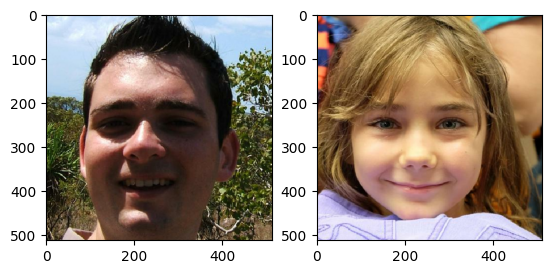

In [18]:
sample_input_batch, sample_real_batch = list(train_dataset.take(1))[0]
print(sample_input_batch.shape)
fig = plt.figure()
fig.add_subplot(1, 2, 1).imshow(sample_input_batch[0] * 0.5 + 0.5)
fig.add_subplot(1, 2, 2).imshow(sample_real_batch[0]  * 0.5 + 0.5)
plt.show()

## Build the generator
The generator is a modified U-Net, consisting of an enoder (downsampler) and decoder (upsampler).
The encoder consists of a number of blocks. Each block contains convolution -> batch normalization -> leaky RELU
The decoder consists of a number of blocks. Each block contains a transposed convolution -> batch normalization -> dropout (in first 3 blocks) -> ReLU
There are skip connections between the encoder and decoder.

In [26]:
def make_downsample_block(filters, size, apply_batch_norm=True):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    #if apply_batch_norm:
    #    block.add(tf.keras.layers.BatchNormalization())
    block.add(tf.keras.layers.LeakyReLU())
    return block


In [20]:
test_image = process_image(sample_image_filename)[1]
test_downsample_block = make_downsample_block(3, 4)
test_downsample_result = test_downsample_block(tf.expand_dims(test_image, 0))
print(test_downsample_result.shape)

(1, 256, 256, 3)


In [28]:
def make_upsample_block(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.2)
    block = tf.keras.Sequential()
    block.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    block.add(tf.keras.layers.BatchNormalization())
    #if apply_dropout:
    #    block.add(tf.keras.layers.Dropout(0.5))
    block.add(tf.keras.layers.ReLU())
    return block

In [29]:
test_upsample_block = make_upsample_block(3, 4)
test_upsample_result = test_upsample_block(test_downsample_result)
print(test_upsample_result.shape)

(1, 512, 512, 3)


In [30]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[512, 512, 3])
    down_stack = [
        make_downsample_block(32,  4, apply_batch_norm=False), # (?, 256, 256,   32)
        make_downsample_block(64,  4),                         # (?, 128, 128,   64)
        make_downsample_block(128, 4),                         # (?,  64,  64,  128)
        make_downsample_block(256, 4),                         # (?,  32,  32,  256)
        make_downsample_block(512, 4),                         # (?,  16,  16,  512)
        make_downsample_block(512, 4),                         # (?,   8,   8,  512)
        make_downsample_block(512, 4),                         # (?,   4,   4,  512)
        make_downsample_block(512, 4),                         # (?,   2,   2,  512)
        make_downsample_block(512, 4),                         # (?,   1,   1,  512)
    ]
    
    up_stack = [
        make_upsample_block(512, 4, apply_dropout=True),       # (?,   2,   2, 1024)
        make_upsample_block(512, 4, apply_dropout=True),       # (?,   4,   4, 1024)
        make_upsample_block(512, 4, apply_dropout=True),       # (?,   8,   8, 1024)
        make_upsample_block(512, 4),                           # (?,  16,  16, 1024)
        make_upsample_block(256, 4),                           # (?,  32,  32,  512)
        make_upsample_block(128, 4),                           # (?,  64,  64,  256)
        make_upsample_block( 64, 4),                           # (?, 128, 128,  128)
        make_upsample_block( 32, 4),                           # (?, 256, 256,   64)
    ]    

    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    # (?, 512, 512, 3)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [31]:
generator = Generator()
# FIXME: his currently fails because we don't have pydot
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

## Test the generator

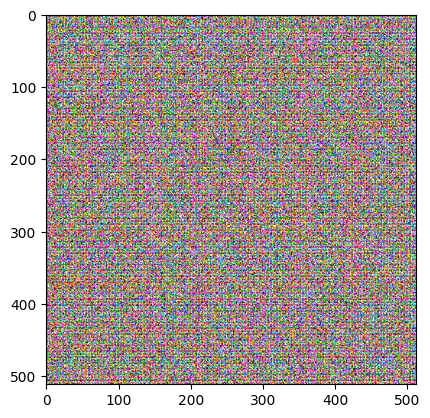

(-1.0, 1.0)

In [32]:
#gen_output = generator(tf.expand_dims(sample_input_image, 0), training=False)
#sample_input_batch, sample_real_batch = list(train_dataset.take(1))[0]
gen_output = generator(sample_input_batch, training=False)
plt.imshow(gen_output[0] * 0.5 + 0.5)
plt.show()
tf.reduce_min(sample_input_image).numpy(), tf.reduce_max(sample_input_image).numpy()

## Define the generator loss

Conditional GANs learn a structured loss. I'm still a bit confused to see what that entails.

In [33]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

## Build the discriminator
The discriminator is a convolutional PatchGAN classifier - it tries to classify if each image *patch* is real or not.
- Each block in the discriminator is convolution -> batch normalization -> leaky ReLU.
- The shape of the output after the last layer is (batch_size, 30, 30, 1).
- Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image
- The discriminator receives two inputs:
  - The input and the target image, which it should classify as real.
  - The input image and the generated image, which it should classify as fake.
  - Using `tf.concat([input, target], axis=-1)` we can concatenate these 2 inputs together.

In [35]:
def Discriminator():
    initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    input_image = tf.keras.layers.Input(shape=[512, 512, 3], name='input_image')
    target_image = tf.keras.layers.Input(shape=[512, 512, 3], name='target_image')
    x = tf.keras.layers.concatenate([input_image, target_image]) # (?, 512, 512,   6)
    down1 = make_downsample_block( 32, 4, False)(x)              # (?, 256, 256,  32)
    down2 = make_downsample_block( 64, 4)(down1)                 # (?, 128, 128,  64)
    down3 = make_downsample_block(128, 4)(down2)                 # (?,  64,  64, 128)
    down4 = make_downsample_block(256, 4)(down3)                 # (?,  32,  32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)           # (?,  34,  34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                  kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)     # (?,  31,  31, 512)
    batch_norm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batch_norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)      # (?,  33,  33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                  kernel_initializer=initializer)(zero_pad2) # (?, 30, 30, 1)
    return tf.keras.Model(inputs=[input_image, target_image], outputs=last)

In [36]:
discriminator = Discriminator()
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

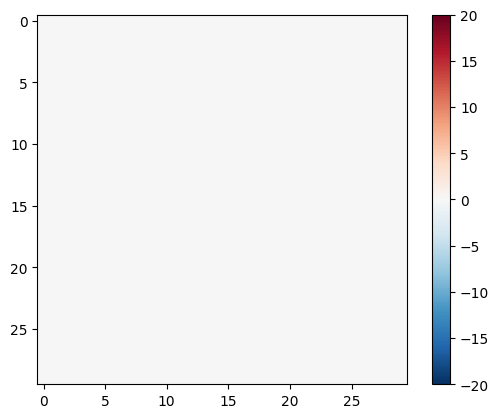

In [37]:
disc_output = discriminator([tf.expand_dims(sample_input_image, 0), tf.expand_dims(gen_output[0], 0)], training=False)
plt.imshow(disc_output[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()
plt.show()

## Define the discriminator loss
The discriminator loss takes real images and generated images.
- `real_loss` is a sigmoid cross-entropy loss of the real images and the array of ones.
- `generated_loss` is a sigmoid cross-entropy loss of the generated images and the arrays of zeros.
- `total_loss` is the sum of the two.

In [38]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_loss = real_loss + generated_loss
    return total_loss

# Define the optimizers and checkpoint saver

In [39]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [40]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Generate images
Define a function that generates images during training.

In [41]:
def save_image(filename, tensor):
    normalized = tensor * 0.5 + 0.5
    image_tensor = tf.cast(normalized * 255, tf.uint8)
    tf.io.write_file(os.path.join(output_image_dir, filename), tf.io.encode_jpeg(image_tensor))

In [42]:
def generate_images(model, test_input, target, save=False, step=1):
    # Training=true is used here since you want the batch statistics
    #print(tf.reduce_min(sample_input_image).numpy(), tf.reduce_max(sample_input_image).numpy())
    #print(test_input.shape, test_input.dtype)
    prediction = model(test_input, training=False)
    #prediction = model(tf.expand_dims(sample_input_image, 0), training=True)
    
    #print(prediction.shape)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], target[0], prediction[0]]
    title = ['Input Image', 'Real Image', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

    if save:
        save_image(f'input-{step:05d}.jpg', test_input[0])
        save_image(f'target-{step:05d}.jpg', target[0])
        save_image(f'output-{step:05d}.jpg', prediction[0])

Test the function:

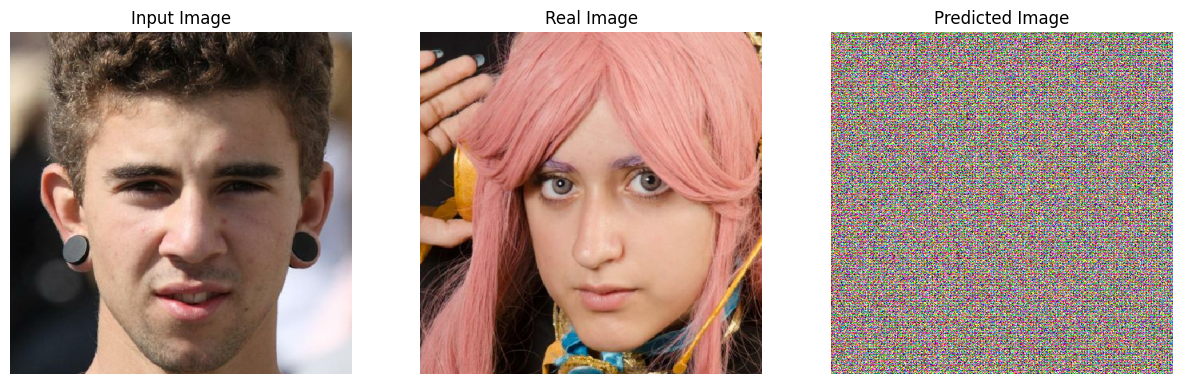

In [43]:
for example_input, example_target in train_dataset.take(1):
    generate_images(generator, example_input, example_target)

In [44]:
summary_writer = tf.summary.create_file_writer(
    log_dir + "/fit/" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [45]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [46]:
def fit(train_ds, steps):
    example_input, example_target = next(iter(train_ds.take(1)))
    start = time.time()
    
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if step % 1000 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
            start = time.time()
            generate_images(generator, example_input, example_target, save=True, step=step//1000)
            print(f'Step: {step//1000}k')

        train_step(input_image, target, step)
        
        if (step + 1) % 10 == 0:
            print('.', end='', flush=True)
            
        if (step + 1) % 20000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [47]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Time taken for 1000 steps: 66.48 sec



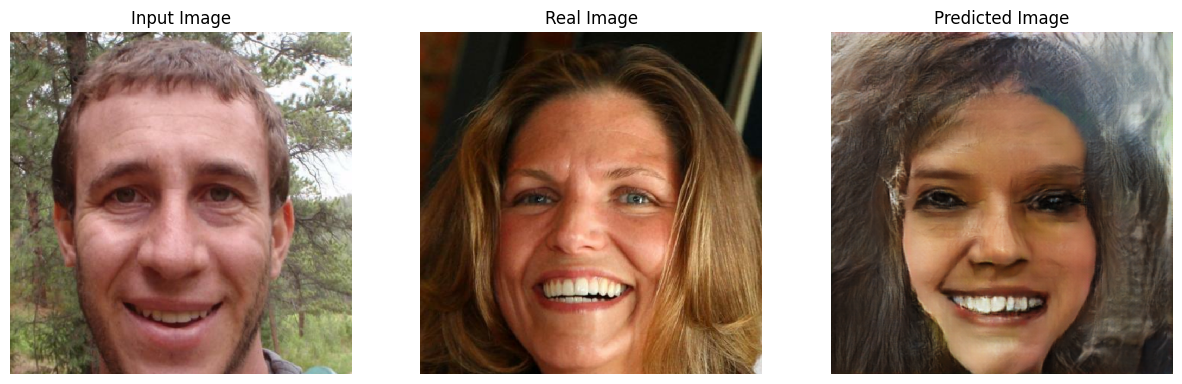

Step: 499k
....................................................................................................

In [48]:
fit(train_dataset, steps=500_000)

In [ ]:
# Maybe save the checkpoint?
checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
#generator.compile_metrics()
generator_dir = os.path.join(model_dir, 'generator-male-to-female')
generator.save(generator_dir)